<a href="https://colab.research.google.com/github/alex433741/FInal-Project/blob/main/NBA_Player_Stats_Predicting_Project_Finalvs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CS 3120 Final Project: Predicting Nikola Jokic stats for future games

For this project I am going to be using data from "Basketball-Refrence.com". The excat data I am using is his 23-24 season stats and all the games up to today 11/21/2024. I exported the two files and put them in an excel sheet that I will upload into this workbook.

For this project I plan to use and test different models like linear regression, GradientBoosting, and neural networks. For missing data I plan to completly remove the rows that are empty since it is games were the player was inactive. I also plan to remove the columns for 3P% and FT%. This is because there are instances were the values are empty because the player didnt attempt a FT or a 3P. But in the columns for FTA and 3PA it will show a 0 since none were attempted. But the percantege for them will be empty and it should not be 0 or any other value.

For measuring the performance of my models I will be using RMSE





In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Jokic_Stats_Machine_Learning_Project.xlsx to Jokic_Stats_Machine_Learning_Project.xlsx


In [ ]:
# Loading the  excel file into a data frame
df = pd.read_excel('Jokic_Stats_Machine_Learning_Project.xlsx')

# Print the shape of the df and first 5 rows of raw data
print(f"** df has {df.shape[0]} rows and {df.shape[1]} columns **")
df.head()


** df has 99 rows and 31 columns **


,Rk,G,Date,Age,Tm,Home/Away,Opp,Result,PD,GS,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,1.0,2023-10-24,28-247,DEN,Home,LAL,W,(+12),1,...,10.0,13.0,11.0,1.0,1.0,2.0,2.0,29.0,29.3,15.0
1,2,2.0,2023-10-27,28-250,DEN,Away,MEM,W,(+4),1,...,9.0,12.0,7.0,1.0,1.0,9.0,1.0,22.0,17.0,6.0
2,3,3.0,2023-10-29,28-252,DEN,Away,OKC,W,(+33),1,...,12.0,14.0,5.0,0.0,0.0,4.0,3.0,28.0,24.9,21.0
3,4,4.0,2023-10-30,28-253,DEN,Home,UTA,W,(+8),1,...,9.0,10.0,11.0,0.0,2.0,1.0,3.0,27.0,29.7,13.0
4,5,5.0,2023-11-01,28-255,DEN,Away,MIN,L,(-21),1,...,8.0,10.0,3.0,0.0,0.0,5.0,0.0,25.0,14.2,-19.0


In [ ]:
# One-hot encoding Home/Away column
# Select the 'Home/Away' column
Home_Away = df['Home/Away']

# Apply one-hot encoding
Home_Away_encoded = pd.get_dummies(Home_Away).astype(int)

# Add the one-hot encoded DataFrame to your main DataFrame
df = pd.concat([df, Home_Away_encoded], axis=1)

In [ ]:
# One-hot encoding result column
# Select the result column
Result = df['Result']

# Apply one-hot encoding
Result_encoded = pd.get_dummies(Result).astype(int)

# Add the one-hot encoded DataFrame to your main DataFrame
df = pd.concat([df, Result_encoded], axis=1)

In [ ]:
# One-hot encoding result Opp column
# Select the Opp column
Opp = df['Opp']

# Apply one-hot encoding
Opp_encoded = pd.get_dummies(Opp).astype(int)

# Add the one-hot encoded DataFrame to your main DataFrame
df = pd.concat([df, Opp_encoded], axis=1)

In [ ]:
# get a list of the column names that are either integers or floats
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = df.select_dtypes(include=numerics).copy()
numeric_df.describe()

,Rk,G,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,...,OKC,ORL,PHI,PHO,POR,SAC,SAS,TOR,UTA,WAS
count,99.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,79.000000,93.000000,93.000000,...,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,50.000000,47.000000,10.505376,18.107527,0.596527,1.225806,3.107527,0.448177,4.655914,5.677419,...,0.060606,0.020202,0.020202,0.030303,0.040404,0.040404,0.040404,0.040404,0.060606,0.020202
std,28.722813,26.990739,3.360977,5.881922,0.149009,1.171482,2.460392,0.329502,3.201544,3.680623,...,0.239821,0.141407,0.141407,0.172292,0.197907,0.197907,0.197907,0.197907,0.239821,0.141407
min,1.000000,1.000000,2.000000,3.000000,0.281000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.500000,24.000000,8.000000,14.000000,0.500000,0.000000,1.000000,0.200000,2.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,47.000000,11.000000,18.000000,0.579000,1.000000,3.000000,0.375000,4.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,74.500000,70.000000,13.000000,22.000000,0.684000,2.000000,5.000000,0.667000,6.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,99.000000,93.000000,18.000000,32.000000,1.000000,7.000000,12.000000,1.000000,18.000000,18.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
print(numeric_df.head())

   Rk    G    FG   FGA    FG%   3P  3PA    3P%   FT  FTA  ...  OKC  ORL  PHI  \
0   1  1.0  12.0  22.0  0.545  3.0  5.0  0.600  2.0  4.0  ...    0    0    0   
1   2  2.0   8.0  14.0  0.571  1.0  4.0  0.250  5.0  6.0  ...    0    0    0   
2   3  3.0  12.0  16.0  0.750  1.0  2.0  0.500  3.0  3.0  ...    1    0    0   
3   4  4.0  12.0  16.0  0.750  1.0  3.0  0.333  2.0  5.0  ...    0    0    0   
4   5  5.0  11.0  23.0  0.478  1.0  6.0  0.167  2.0  2.0  ...    0    0    0   

   PHO  POR  SAC  SAS  TOR  UTA  WAS  
0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0  
3    0    0    0    0    0    1    0  
4    0    0    0    0    0    0    0  

[5 rows x 56 columns]


In [ ]:
# See which rows in numeric_df have more than 20 missing values meaning player was inactive
missing = numeric_df.isnull().sum(axis=1)
missing = missing[missing > 20]
print(missing)

17    21
48    21
70    21
92    21
93    21
94    21
dtype: int64


In [ ]:
# Remove these rows from the DataFrame
nrows_before = numeric_df.shape[0]
numeric_df = numeric_df.drop(index=missing.index)
nrows_after = numeric_df.shape[0]
print(f"** Removed {nrows_before - nrows_after} rows **")

** Removed 6 rows **


In [ ]:
# See which columns in numeric_df has missing values
missing = numeric_df.isnull().sum()
missing = missing[missing > 0]
print(missing)


3P%    14
FT%     4
dtype: int64


In [ ]:
# Remove these columns from the DataFrame
ncols_before = numeric_df.shape[1]
numeric_df = numeric_df.drop(columns=missing.index)
ncols_after = numeric_df.shape[1]
print(f"** Removed {ncols_before - ncols_after} columns **")

** Removed 2 columns **


In [ ]:
# Feature engineering
# Adding rolling avg and replacing NaN with 0
numeric_df['avg_points_last_5'] = numeric_df['PTS'].rolling(window=5).mean().fillna(0)
numeric_df['avg_assist_last_5'] = numeric_df['AST'].rolling(window=5).mean().fillna(0)
numeric_df['avg_rebounds_last_5'] = numeric_df['TRB'].rolling(window=5).mean().fillna(0)
numeric_df['avg_FG_last_5'] = numeric_df['FG'].rolling(window=5).mean().fillna(0)
numeric_df['avg_FGA_last_5'] = numeric_df['FGA'].rolling(window=5).mean().fillna(0)


In [ ]:
numeric_df.head()

,Rk,G,FG,FGA,FG%,3P,3PA,FT,FTA,ORB,...,SAC,SAS,TOR,UTA,WAS,avg_points_last_5,avg_assist_last_5,avg_rebounds_last_5,avg_FG_last_5,avg_FGA_last_5
0,1,1.0,12.0,22.0,0.545,3.0,5.0,2.0,4.0,3.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,2,2.0,8.0,14.0,0.571,1.0,4.0,5.0,6.0,3.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
2,3,3.0,12.0,16.0,0.750,1.0,2.0,3.0,3.0,2.0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
3,4,4.0,12.0,16.0,0.750,1.0,3.0,2.0,5.0,1.0,...,0,0,0,1,0,0.0,0.0,0.0,0.0,0.0
4,5,5.0,11.0,23.0,0.478,1.0,6.0,2.0,2.0,2.0,...,0,0,0,0,0,26.2,7.4,11.8,11.0,18.2


In [ ]:
print(numeric_df.columns)

Index(['Rk', 'G', 'FG', 'FGA', 'FG%', '3P', '3PA', 'FT', 'FTA', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+/-', 'Away',
       'Home', 'L', 'L ', 'W', 'ATL', 'BOS', 'BRK', 'CHI', 'CHO', 'CLE', 'DAL',
       'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN',
       'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHO', 'POR', 'SAC', 'SAS', 'TOR',
       'UTA', 'WAS', 'avg_points_last_5', 'avg_assist_last_5',
       'avg_rebounds_last_5', 'avg_FG_last_5', 'avg_FGA_last_5'],
      dtype='object')


In [ ]:
X = numeric_df.drop(columns=['Rk', 'G', 'W', 'L', 'L ']).copy()
y = numeric_df['W'].copy()

In [ ]:
print(X.shape)
print(y.shape)

(93, 54)
(93,)


In [ ]:
# Sort the columns of X according to how strong their correlation is with W
correlations = X.corrwith(y).abs().sort_values(ascending=False)
X = X[correlations.index]
X.head()

,+/-,3PA,FG%,GmSc,ORL,BLK,LAC,SAC,HOU,FGA,...,FG,DAL,STL,PTS,ORB,PF,SAS,FT,FTA,NOP
0,15.0,5.0,0.545,29.3,0,1.0,0,0,0,22.0,...,12.0,0,1.0,29.0,3.0,2.0,0,2.0,4.0,0
1,6.0,4.0,0.571,17.0,0,1.0,0,0,0,14.0,...,8.0,0,1.0,22.0,3.0,1.0,0,5.0,6.0,0
2,21.0,2.0,0.750,24.9,0,0.0,0,0,0,16.0,...,12.0,0,0.0,28.0,2.0,3.0,0,3.0,3.0,0
3,13.0,3.0,0.750,29.7,0,2.0,0,0,0,16.0,...,12.0,0,0.0,27.0,1.0,3.0,0,2.0,5.0,0
4,-19.0,6.0,0.478,14.2,0,0.0,0,0,0,23.0,...,11.0,0,0.0,25.0,2.0,0.0,0,2.0,2.0,0


In [ ]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Logistic Regression --------------------------

In [ ]:
# Fit a regression model to the data using only the first column of X to predict y
model_lr = LogisticRegression()
num_features = X.shape[1]

rmse_values_lr = []
pred_rmse_values_lr = []
min_features = 1
for i in range(min_features, num_features + 1):
    model_lr.fit(X_train.iloc[:,0:i], y_train)
    mse = np.sqrt(np.mean((y_train - model_lr.predict(X_train.iloc[:,0:i]))**2))
    pred_mse = np.sqrt(np.mean((y_test - model_lr.predict(X_test.iloc[:,0:i]))**2))
    rmse_values_lr.append(mse)
    pred_rmse_values_lr.append(pred_mse)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

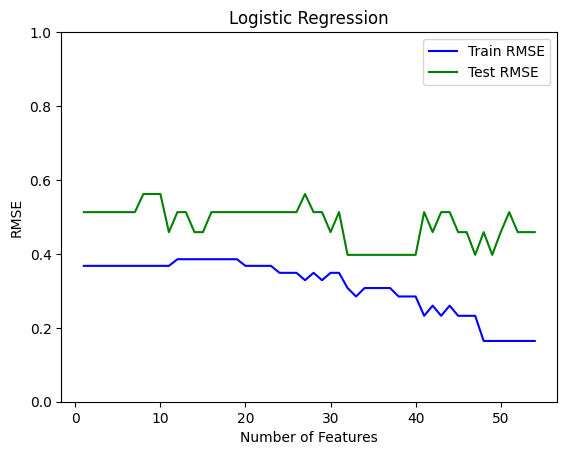

Accuracy: 0.79
ROC-AUC: 0.86
              precision    recall  f1-score   support

           0       0.62      0.83      0.71         6
           1       0.91      0.77      0.83        13

    accuracy                           0.79        19
   macro avg       0.77      0.80      0.77        19
weighted avg       0.82      0.79      0.80        19



In [ ]:
# Plot the rmse values
plt.plot(range(min_features, num_features + 1), rmse_values_lr, label='Train RMSE', color='blue')
plt.plot(range(min_features, num_features + 1), pred_rmse_values_lr, label='Test RMSE', color='green')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.ylim(0, 1)
plt.title('Logistic Regression')
plt.legend()
plt.show()

# Make predictions
y_pred = model_lr.predict(X_test)
y_pred_proba = model_lr.predict_proba(X_test)[:, 1]

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")
print(classification_report(y_test, y_pred))

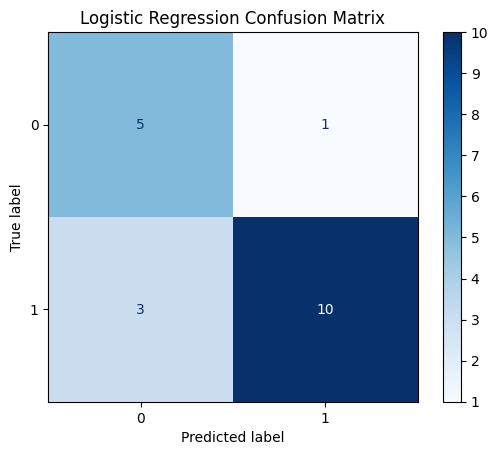

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lr.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Decision Tree ----------------------------

In [ ]:
# Decision Tree Classifier
rmse_values_dt = []
pred_rmse_values_dt = []
max_depths = range(1, 50)
for i in range(len(max_depths)):
    model_dt = DecisionTreeClassifier(max_depth=max_depths[i])
    model_dt.fit(X_train, y_train)
    mse = np.sqrt(np.mean((y_train - model_dt.predict(X_train))**2))
    pred_mse = np.sqrt(np.mean((y_test - model_dt.predict(X_test))**2))
    rmse_values_dt.append(mse)
    pred_rmse_values_dt.append(pred_mse)

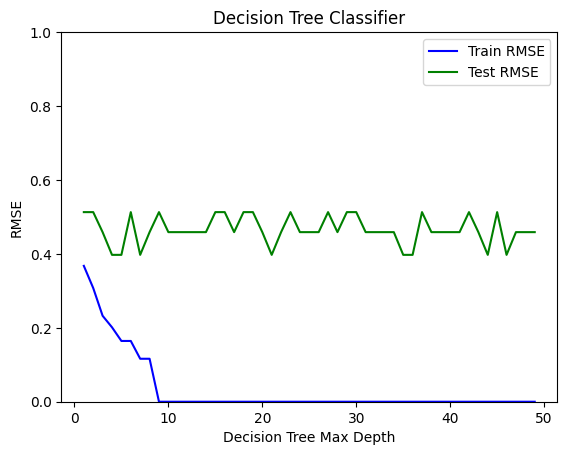

Accuracy: 0.79
ROC-AUC: 0.71
              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.80      0.92      0.86        13

    accuracy                           0.79        19
   macro avg       0.78      0.71      0.73        19
weighted avg       0.78      0.79      0.78        19



In [ ]:
# Plot the rmse values
plt.plot(range(min(max_depths), max(max_depths)+1), rmse_values_dt, label='Train RMSE', color='blue')
plt.plot(range(min(max_depths), max(max_depths)+1), pred_rmse_values_dt, label='Test RMSE', color='green')
plt.xlabel('Decision Tree Max Depth')
plt.ylabel('RMSE')
plt.title('Decision Tree Classifier')
plt.ylim(0, 1)
plt.legend()
plt.show()

 # Make predictions
y_pred = model_dt.predict(X_test)
y_pred_proba = model_dt.predict_proba(X_test)[:, 1]

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")
print(classification_report(y_test, y_pred))

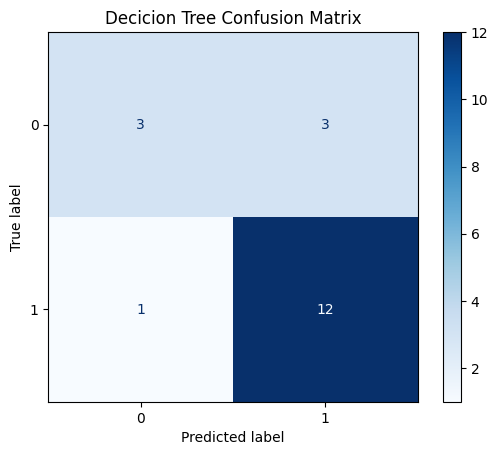

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_dt.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Decicion Tree Confusion Matrix")
plt.show()

# Random Forest ------------------------


In [ ]:
# Random Forest Model Classifier
rmse_values_dt = []
pred_rmse_values_dt = []
poss_num_estimators = list(range(1, 102, 5))
for i in range(len(poss_num_estimators)):
    #print(f"** num_estimators = {poss_num_estimators[i]} **")
    model_rf = RandomForestClassifier(n_estimators=poss_num_estimators[i], min_samples_leaf=1, random_state=2)
    model_rf.fit(X_train, y_train)
    mse = np.sqrt(np.mean((y_train - model_rf.predict(X_train))**2))
    pred_mse = np.sqrt(np.mean((y_test - model_rf.predict(X_test))**2))
    rmse_values_dt.append(mse)
    pred_rmse_values_dt.append(pred_mse)

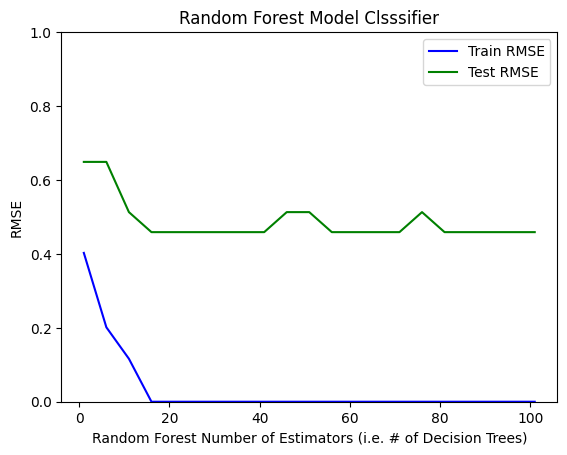

Accuracy: 0.79
ROC-AUC: 0.78
              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.80      0.92      0.86        13

    accuracy                           0.79        19
   macro avg       0.78      0.71      0.73        19
weighted avg       0.78      0.79      0.78        19



In [ ]:
# Plot the rmse values
plt.plot(poss_num_estimators, rmse_values_dt, label='Train RMSE', color='blue')
plt.plot(poss_num_estimators, pred_rmse_values_dt, label='Test RMSE', color='green')
plt.xlabel('Random Forest Number of Estimators (i.e. # of Decision Trees)')
plt.ylabel('RMSE')
plt.title('Random Forest Model Clsssifier')
plt.ylim(0, 1)
plt.legend()
plt.show()

 # Make predictions
y_pred = model_rf.predict(X_test)
y_pred_proba = model_rf.predict_proba(X_test)[:, 1]

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")
print(classification_report(y_test, y_pred))

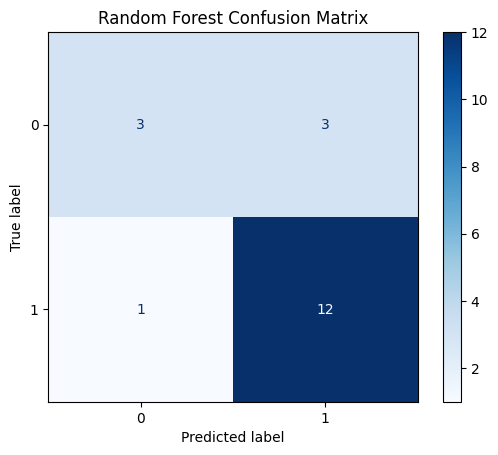

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Random Forest Confusion Matrix")
plt.show()

# Gradiant Boosting Classifier --------------------------

In [ ]:
# Gradient Boosting Classifier
rmse_values_dt = []
pred_rmse_values_dt = []
poss_num_estimators = list(range(1, 50))
for i in range(len(poss_num_estimators)):
    #print(f"** num_estimators = {poss_num_estimators[i]} **")
    model_gb = GradientBoostingClassifier(n_estimators=poss_num_estimators[i], learning_rate=0.1, random_state=2)
    model_gb.fit(X_train, y_train)
    mse = np.sqrt(np.mean((y_train - model_gb.predict(X_train))**2))
    pred_mse = np.sqrt(np.mean((y_test - model_gb.predict(X_test))**2))
    rmse_values_dt.append(mse)
    pred_rmse_values_dt.append(pred_mse)

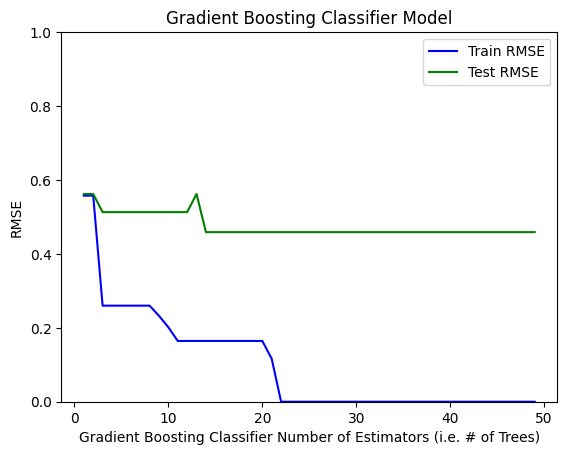

Accuracy: 0.79
ROC-AUC: 0.86
              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.80      0.92      0.86        13

    accuracy                           0.79        19
   macro avg       0.78      0.71      0.73        19
weighted avg       0.78      0.79      0.78        19



In [ ]:
# Plot the rmse values
plt.plot(poss_num_estimators, rmse_values_dt, label='Train RMSE', color='blue')
plt.plot(poss_num_estimators, pred_rmse_values_dt, label='Test RMSE', color='green')
plt.xlabel('Gradient Boosting Classifier Number of Estimators (i.e. # of Trees)')
plt.ylabel('RMSE')
plt.title('Gradient Boosting Classifier Model')
plt.ylim(0, 1)
plt.legend()
plt.show()

 # Make predictions
y_pred = model_gb.predict(X_test)
y_pred_proba = model_gb.predict_proba(X_test)[:, 1]

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")
print(classification_report(y_test, y_pred))

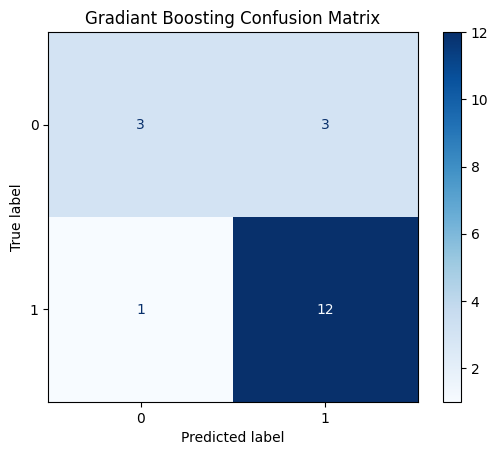

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_gb.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Gradiant Boosting Confusion Matrix")
plt.show()